In [1]:
import numpy
from matplotlib import pyplot
import py_monte_carlo
import scipy.sparse
import scipy.linalg

## Including Transverse field

In [2]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0), ((4, 0), -1.0)]
transverse = 1.0
nvars = 5
betas = 10**numpy.linspace(-1,1,10)

graphs = py_monte_carlo.LatticeTempering(edges)

for beta in betas:
    graphs.add_graph(transverse, beta)

In [3]:
graphs.qmc_timesteps(10000)
results, energies = graphs.qmc_timesteps_sample(10000, replica_swap_freq=1, sampling_freq=1)
q_transverse_data = numpy.mean(numpy.sum(results*2 - 1, axis=-1)**2, axis=-1)
graphs.get_total_swaps() / (len(betas) * 10000)

0.20411

In [4]:
def make_ham_and_spin(nvars, edges, transverse):
    ham = numpy.zeros((2**nvars,2**nvars))
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        for j in range(i+1, 2**nvars):
            b_state = [(j >> k) & 1 for k in range(nvars)]
            diffstate = [a^b for a,b in zip(state, b_state)]
            if sum(diffstate) != 1:
                continue
            for vark,s in enumerate(diffstate):
                if not s:
                    continue
                ham[i, j] = ham[i,j] + transverse
                ham[j, i] = ham[j,i] + transverse

    spin_diag = []
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1)**2)
    spin_op = numpy.diag(spin_diag)
    return ham, spin_op

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

In [5]:
ed_transverse_data = []
ed_transverse_energies = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    ed_transverse_energies.append(numpy.trace(ham @ expm) / numpy.trace(expm))

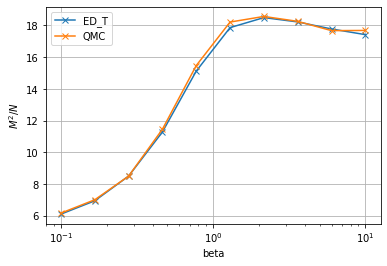

In [6]:
pyplot.plot(betas, ed_transverse_data, 'x-', label="ED_T")
pyplot.plot(betas, q_transverse_data, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

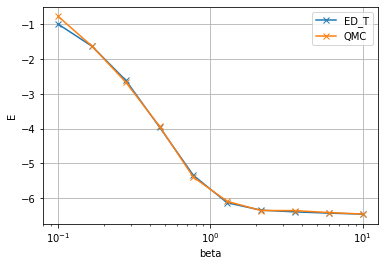

In [7]:
pyplot.plot(betas, ed_transverse_energies, 'x-', label="ED_T")
pyplot.plot(betas, energies, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

## Autocorr

In [8]:
n = 256
edges = [((x, (x+1) % n), -1.0) for x in range(n)]
transverse = 0.2
betas = 2**numpy.linspace(-3,1,16)
graphs = py_monte_carlo.LatticeTempering(edges)

for beta in betas:
    graphs.add_graph(transverse, beta)
results = graphs.run_quantum_monte_carlo_and_measure_bond_autocorrelation(1000, sampling_wait_buffer=1000, replica_swap_freq=10000)

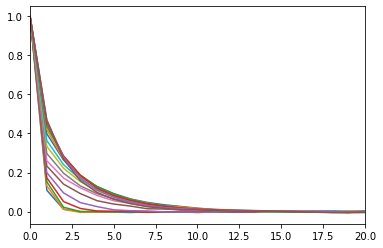

In [9]:
for i in range(results.shape[0]):
    pyplot.plot(results[i,:])
pyplot.xlim((0,20))
pyplot.show()

In [10]:
n = 256
edges = [((x, (x+1) % n), -1.0) for x in range(n)]
transverse = 0.2
betas = 2**numpy.linspace(-3,1,16)
graphs = py_monte_carlo.LatticeTempering(edges)

for beta in betas:
    graphs.add_graph(transverse, beta)
new_results = graphs.run_quantum_monte_carlo_and_measure_bond_autocorrelation(1000, sampling_wait_buffer=1000, replica_swap_freq=1)

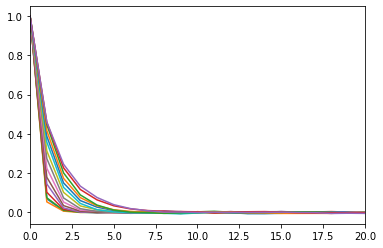

In [11]:
for i in range(results.shape[0]):
    pyplot.plot(new_results[i,:])
pyplot.xlim((0,20))
pyplot.show()

## Checkerboard

In [12]:
class Graph:
    def __init__(self, x_side_len=8, y_side_len=8):
        self.x_side_len = x_side_len
        self.y_side_len = y_side_len
        self.nvars = self.x_side_len*self.y_side_len

        self.x = numpy.arange(self.x_side_len)
        self.y = numpy.arange(self.y_side_len)
        self.X, self.Y = numpy.meshgrid(self.x, self.y)

        INDX = self.Y*self.x_side_len + self.X
        RIGHT = self.Y*self.x_side_len + (self.X+1)%self.x_side_len

        below = (self.Y+1) % self.y_side_len 
        BOT = below*self.x_side_len + self.X

        right_edges = [((a, b), 1.0) for a, b in zip(INDX.flatten(), RIGHT.flatten())]
        bot_edges = [((a, b), 1.0) for a, b in zip(INDX.flatten(), BOT.flatten())]

        lefts = [((x,y), ((x+1)%self.x_side_len, (y+1)%self.y_side_len))
                 for x,y in zip(self.X.flatten(), self.Y.flatten()) 
                 if (x+y)%2 == 0]
        rights = [((x,y), ((x-1)%self.x_side_len, (y+1)%self.y_side_len))
                  for x,y in zip(self.X.flatten(), self.Y.flatten()) 
                  if (x+y)%2 == 1]
        cross_edges = [(y1*self.x_side_len + x1, y2*self.x_side_len + x2) for (x1, y1), (x2, y2) in lefts+rights]
        cross_edges = [(v, 1.0) for v in cross_edges]

        self.edges =  right_edges + bot_edges + cross_edges
        self.edge_list = numpy.asarray([(a, b) for ((a, b),_) in self.edges])
        self.edge_values = numpy.asarray([j for _, j in self.edges])


    def run_samples(self, gamma, beta, timesteps, num_experiments=16, load_only=False):
        graph = py_monte_carlo.Lattice(self.edges)
        graph.set_transverse_field(gamma)
        energies, samples = graph.run_quantum_monte_carlo_sampling(beta, timesteps, num_experiments)
        return energies, samples

    def plot_it(self):
        for (a, b) in self.edge_list:
            ax, ay = a % self.x_side_len, a // self.x_side_len
            bx, by = b % self.x_side_len, b // self.x_side_len
            c = 'blue'

            if abs(ax - bx) > 1 or abs(ay - by) > 1:
                pyplot.plot([ax, bx], [ay, by], alpha=0.1, c=c)
            else:
                pyplot.plot([ax, bx], [ay, by], c=c)
        pyplot.show()

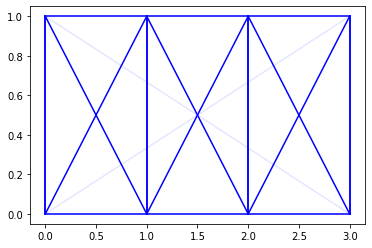

In [13]:
g = Graph(4, 2)
g.plot_it()

In [14]:
transverse = 1.0
betas = 10**numpy.linspace(-1,1,10)

checkerboard_q_transverse_data = numpy.zeros((len(betas),))
for i,beta in enumerate(betas):
    _, results = g.run_samples(transverse, beta, 10000, num_experiments=16)
    checkerboard_q_transverse_data[i] = numpy.mean(numpy.sum(results*2 - 1, axis=-1)**2)

In [15]:
graphs = py_monte_carlo.LatticeTempering(g.edges)
for beta in betas:
    graphs.add_graph(transverse, beta)

results, energies = graphs.qmc_timesteps_sample(10000, 1)
checkerboard_replicas_transverse_data = numpy.mean(numpy.sum(results*2 - 1, axis=-1)**2, axis=-1)

In [16]:
ham, spin_op = make_ham_and_spin(g.nvars, g.edges, transverse)

checkerboard_ed_transverse_data = []
checkerboard_ed_transverse_energies = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    checkerboard_ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    checkerboard_ed_transverse_energies.append(numpy.trace(ham @ expm) / numpy.trace(expm))

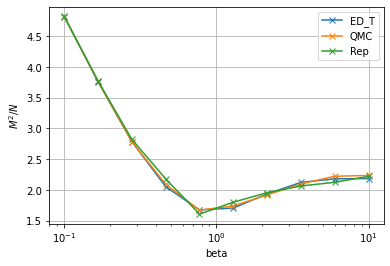

In [17]:
pyplot.plot(betas, checkerboard_ed_transverse_data, 'x-', label="ED_T")
pyplot.plot(betas, checkerboard_q_transverse_data, 'x-', label="QMC")
pyplot.plot(betas, checkerboard_replicas_transverse_data, 'x-', label="Rep")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

In [18]:
gammas = 10**numpy.linspace(-1,1,20)
beta = 1

In [19]:
checkerboard_q_transverse_data = numpy.zeros((len(gammas),))
for i, transverse in enumerate(gammas):
    _, results = g.run_samples(transverse, beta, 10000, num_experiments=8)
    checkerboard_q_transverse_data[i] = numpy.mean(numpy.sum(results*2 - 1, axis=-1)**2)

In [20]:
graphs = py_monte_carlo.LatticeTempering(g.edges)
for transverse in gammas:
    graphs.add_graph(transverse, beta)

results, energies = graphs.qmc_timesteps_sample(10000, 1)
checkerboard_replicas_transverse_data = numpy.mean(numpy.sum(results*2 - 1, axis=-1)**2, axis=-1)

In [21]:
checkerboard_ed_transverse_data = []
checkerboard_ed_transverse_energies = []
for transverse in gammas:
    ham, spin_op = make_ham_and_spin(g.nvars, g.edges, transverse)
    expm = scipy.linalg.expm(-beta*ham)
    checkerboard_ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    checkerboard_ed_transverse_energies.append(numpy.trace(ham @ expm) / numpy.trace(expm))

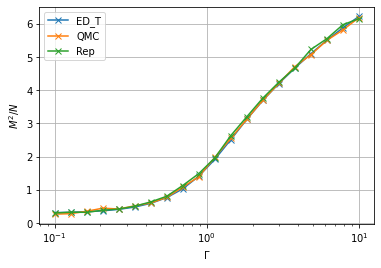

In [22]:
pyplot.plot(gammas, checkerboard_ed_transverse_data, 'x-', label="ED_T")
pyplot.plot(gammas, checkerboard_q_transverse_data, 'x-', label="QMC")
pyplot.plot(gammas, checkerboard_replicas_transverse_data, 'x-', label="Rep")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel(r"$\Gamma$")
pyplot.ylabel("$M^2/N$")
pyplot.show()